## Load Tensorboard

In [1]:
%load_ext tensorboard

## Import Libraries

In [2]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19

## Initialize Tensorflow

In [3]:
from tensorflow.keras import backend as K
K.clear_session()

## Load Data

In [4]:
data = pd.read_csv("../labels.csv")
imgs = ["{}.jpg".format(x) for x in list(data.id)]
img_label = list(data['breed'])

# Split data into train and validation set equally
b_sp = StratifiedShuffleSplit(1, 0.1)
imgs = np.array(imgs)
img_label = np.array(img_label)
for train_idx, val_idx in b_sp.split(imgs, img_label):
    train_x = imgs[train_idx]
    train_y = img_label[train_idx]
    val_x = imgs[val_idx]
    val_y = img_label[val_idx]

train_y = train_y.astype(str)
val_y = val_y.astype(str)
train_data = pd.DataFrame({'id': train_x,'breed': train_y})
val_data = pd.DataFrame({'id': val_x,'breed': val_y})

In [5]:
BATCH_SIZE = 160

# Number of epochs for training
EPOCHS = 200

# The original image will be resized to the size specified below.
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Path to image for training
#TRAIN_PATH = '../img/train/'
TRAIN_PATH = '../img/train/'
TEST_PATH = '../img/test/'

## Preprocess Image

In [6]:
# For train image generator, more params may be added to generate augmented image.
train_image_generator = ImageDataGenerator(rescale=1./255)
val_image_generator = ImageDataGenerator(rescale=1./255)

In [7]:
train_data_gen = train_image_generator.flow_from_dataframe(
                                        dataframe = train_data,
                                        directory=TRAIN_PATH,x_col="id",
                                        y_col="breed",
                                        class_mode="categorical",
                                        target_size=(IMG_HEIGHT,IMG_WIDTH),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)
val_data_gen = val_image_generator.flow_from_dataframe(
                                        dataframe = val_data,
                                        directory=TRAIN_PATH,x_col="id",
                                        y_col="breed",
                                        class_mode="categorical",
                                        target_size=(IMG_HEIGHT,IMG_WIDTH),
                                        batch_size=BATCH_SIZE)

Found 9199 validated image filenames belonging to 120 classes.
Found 1023 validated image filenames belonging to 120 classes.


In [8]:
# For checking of class distribution in train and validation set
# If unused, leave this commented to reduce output on your screen.

# breedcnt = dict()
# breedcntval = dict()
# for i in train_data['breed']:
#     try:
#         breedcnt[i] += 1
#     except:
#         breedcnt[i] = 1
        
# for i in val_data['breed']:
#     try:
#         breedcntval[i] += 1
#     except:
#         breedcntval[i] = 1
        
# for i in breedcnt.keys():
#     print(i, " : ", breedcnt[i], " | ", breedcntval[i])

## Define Model

In [9]:
# Define you model here
# The model provided is just placeholder
# Do not modify the input shape and the output layer
def get_base_model():
    vgg_model = VGG19(include_top=False, weights='imagenet',
                       input_shape=(IMG_HEIGHT,IMG_WIDTH, 3), pooling='avg')
    vgg_model.trainable = False
    vgg_model.summary()
    input1 = Input(shape=(IMG_HEIGHT,IMG_WIDTH, 3))
    vgg_layer = vgg_model(input1)
    out = Dense(120, activation='softmax')(vgg_layer)
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy',
                  metrics=['categorical_crossentropy','categorical_accuracy','accuracy'])
    
    return model

In [10]:
base_model = get_base_model()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
# Total params should not exceed 120M or the VM may crash
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense (Dense)                (None, 120)               61560     
Total params: 20,085,944
Trainable params: 61,560
Non-trainable params: 20,024,384
_________________________________________________________________


## Train the model

In [12]:
# Path to save model parameters
weight_path_model_base ='model_vgg19_2.h5'
# Path to write tensorboard
tensorboard_path_model_base = 'Graphs/pattern_nn_vgg19_2'

callbacks_list_model_base = [
    TensorBoard(log_dir=tensorboard_path_model_base, histogram_freq=1, write_graph=True, write_grads=True),
    ModelCheckpoint(
            weight_path_model_base,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-10),
    EarlyStopping(
        monitor='val_loss', 
        verbose=1,
        patience=20,
        mode='min',
        restore_best_weights=True)
]

# If get ResourceExhaustedError, Restart kernel, then reduce epoch size (in cell above)
history_base = base_model.fit_generator(train_data_gen, epochs=EPOCHS, verbose=1, validation_data=val_data_gen,
                                        callbacks=callbacks_list_model_base)

Epoch 1/200
57/58 [============================>.] - ETA: 1s - loss: 4.7988 - categorical_crossentropy: 4.7989 - categorical_accuracy: 0.0149 - accuracy: 0.0149
Epoch 00001: val_loss improved from inf to 4.70081, saving model to model_vgg19_2.h5
58/58 [==============================] - 92s 2s/step - loss: 4.7974 - categorical_crossentropy: 4.7974 - categorical_accuracy: 0.0150 - accuracy: 0.0150 - val_loss: 4.7008 - val_categorical_crossentropy: 4.7049 - val_categorical_accuracy: 0.0244 - val_accuracy: 0.0244
Epoch 2/200
57/58 [============================>.] - ETA: 1s - loss: 4.6613 - categorical_crossentropy: 4.6615 - categorical_accuracy: 0.0367 - accuracy: 0.0367
Epoch 00002: val_loss improved from 4.70081 to 4.61059, saving model to model_vgg19_2.h5
58/58 [==============================] - 80s 1s/step - loss: 4.6605 - categorical_crossentropy: 4.6607 - categorical_accuracy: 0.0370 - accuracy: 0.0370 - val_loss: 4.6106 - val_categorical_crossentropy: 4.6144 - val_categorical_accura

Epoch 17/200
57/58 [============================>.] - ETA: 1s - loss: 3.7766 - categorical_crossentropy: 3.7760 - categorical_accuracy: 0.2233 - accuracy: 0.2233
Epoch 00017: val_loss improved from 3.98519 to 3.94648, saving model to model_vgg19_2.h5
58/58 [==============================] - 80s 1s/step - loss: 3.7763 - categorical_crossentropy: 3.7757 - categorical_accuracy: 0.2221 - accuracy: 0.2221 - val_loss: 3.9465 - val_categorical_crossentropy: 3.9463 - val_categorical_accuracy: 0.1623 - val_accuracy: 0.1623
Epoch 18/200
57/58 [============================>.] - ETA: 1s - loss: 3.7357 - categorical_crossentropy: 3.7357 - categorical_accuracy: 0.2279 - accuracy: 0.2279
Epoch 00018: val_loss improved from 3.94648 to 3.90881, saving model to model_vgg19_2.h5
58/58 [==============================] - 80s 1s/step - loss: 3.7369 - categorical_crossentropy: 3.7363 - categorical_accuracy: 0.2272 - accuracy: 0.2272 - val_loss: 3.9088 - val_categorical_crossentropy: 3.9177 - val_categorical_

Epoch 33/200
57/58 [============================>.] - ETA: 1s - loss: 3.3159 - categorical_crossentropy: 3.3158 - categorical_accuracy: 0.3079 - accuracy: 0.3079
Epoch 00033: val_loss did not improve from 3.64740
58/58 [==============================] - 80s 1s/step - loss: 3.3159 - categorical_crossentropy: 3.3158 - categorical_accuracy: 0.3072 - accuracy: 0.3072 - val_loss: 3.6551 - val_categorical_crossentropy: 3.6485 - val_categorical_accuracy: 0.2063 - val_accuracy: 0.2063
Epoch 34/200
57/58 [============================>.] - ETA: 1s - loss: 3.2914 - categorical_crossentropy: 3.2931 - categorical_accuracy: 0.3091 - accuracy: 0.3091
Epoch 00034: val_loss improved from 3.64740 to 3.62025, saving model to model_vgg19_2.h5
58/58 [==============================] - 80s 1s/step - loss: 3.2915 - categorical_crossentropy: 3.2931 - categorical_accuracy: 0.3092 - accuracy: 0.3092 - val_loss: 3.6202 - val_categorical_crossentropy: 3.6346 - val_categorical_accuracy: 0.2023 - val_accuracy: 0.202

57/58 [============================>.] - ETA: 1s - loss: 3.0149 - categorical_crossentropy: 3.0147 - categorical_accuracy: 0.3593 - accuracy: 0.3593
Epoch 00049: val_loss improved from 3.46955 to 3.46414, saving model to model_vgg19_2.h5
58/58 [==============================] - 80s 1s/step - loss: 3.0169 - categorical_crossentropy: 3.0167 - categorical_accuracy: 0.3590 - accuracy: 0.3590 - val_loss: 3.4641 - val_categorical_crossentropy: 3.4753 - val_categorical_accuracy: 0.2160 - val_accuracy: 0.2160
Epoch 50/200
57/58 [============================>.] - ETA: 1s - loss: 3.0009 - categorical_crossentropy: 3.0013 - categorical_accuracy: 0.3605 - accuracy: 0.3605
Epoch 00050: val_loss did not improve from 3.46414
58/58 [==============================] - 79s 1s/step - loss: 3.0010 - categorical_crossentropy: 3.0013 - categorical_accuracy: 0.3604 - accuracy: 0.3604 - val_loss: 3.4659 - val_categorical_crossentropy: 3.4694 - val_categorical_accuracy: 0.2131 - val_accuracy: 0.2131
Epoch 51/20

58/58 [==============================] - 80s 1s/step - loss: 2.7940 - categorical_crossentropy: 2.7949 - categorical_accuracy: 0.4020 - accuracy: 0.4020 - val_loss: 3.3599 - val_categorical_crossentropy: 3.3665 - val_categorical_accuracy: 0.2336 - val_accuracy: 0.2336
Epoch 66/200
57/58 [============================>.] - ETA: 1s - loss: 2.7842 - categorical_crossentropy: 2.7835 - categorical_accuracy: 0.4039 - accuracy: 0.4039
Epoch 00066: val_loss did not improve from 3.35987
58/58 [==============================] - 79s 1s/step - loss: 2.7837 - categorical_crossentropy: 2.7830 - categorical_accuracy: 0.4043 - accuracy: 0.4043 - val_loss: 3.3616 - val_categorical_crossentropy: 3.3664 - val_categorical_accuracy: 0.2287 - val_accuracy: 0.2287
Epoch 67/200
57/58 [============================>.] - ETA: 1s - loss: 2.7740 - categorical_crossentropy: 2.7757 - categorical_accuracy: 0.4018 - accuracy: 0.4018
Epoch 00067: val_loss did not improve from 3.35987
58/58 [=============================

57/58 [============================>.] - ETA: 1s - loss: 2.6212 - categorical_crossentropy: 2.6204 - categorical_accuracy: 0.4395 - accuracy: 0.4395
Epoch 00082: val_loss did not improve from 3.28970
58/58 [==============================] - 80s 1s/step - loss: 2.6226 - categorical_crossentropy: 2.6218 - categorical_accuracy: 0.4395 - accuracy: 0.4395 - val_loss: 3.3082 - val_categorical_crossentropy: 3.2910 - val_categorical_accuracy: 0.2454 - val_accuracy: 0.2454
Epoch 83/200
57/58 [============================>.] - ETA: 1s - loss: 2.6169 - categorical_crossentropy: 2.6175 - categorical_accuracy: 0.4411 - accuracy: 0.4411
Epoch 00083: val_loss improved from 3.28970 to 3.28731, saving model to model_vgg19_2.h5
58/58 [==============================] - 80s 1s/step - loss: 2.6183 - categorical_crossentropy: 2.6188 - categorical_accuracy: 0.4414 - accuracy: 0.4414 - val_loss: 3.2873 - val_categorical_crossentropy: 3.2903 - val_categorical_accuracy: 0.2454 - val_accuracy: 0.2454
Epoch 84/20

Epoch 99/200
57/58 [============================>.] - ETA: 1s - loss: 2.5888 - categorical_crossentropy: 2.5894 - categorical_accuracy: 0.4470 - accuracy: 0.4470
Epoch 00099: val_loss improved from 3.25888 to 3.25436, saving model to model_vgg19_2.h5
58/58 [==============================] - 80s 1s/step - loss: 2.5868 - categorical_crossentropy: 2.5873 - categorical_accuracy: 0.4485 - accuracy: 0.4485 - val_loss: 3.2544 - val_categorical_crossentropy: 3.2790 - val_categorical_accuracy: 0.2444 - val_accuracy: 0.2444
Epoch 100/200
57/58 [============================>.] - ETA: 1s - loss: 2.5870 - categorical_crossentropy: 2.5869 - categorical_accuracy: 0.4478 - accuracy: 0.4478
Epoch 00100: val_loss did not improve from 3.25436
58/58 [==============================] - 79s 1s/step - loss: 2.5869 - categorical_crossentropy: 2.5868 - categorical_accuracy: 0.4481 - accuracy: 0.4481 - val_loss: 3.2692 - val_categorical_crossentropy: 3.2789 - val_categorical_accuracy: 0.2444 - val_accuracy: 0.24

Epoch 116/200
57/58 [============================>.] - ETA: 1s - loss: 2.5845 - categorical_crossentropy: 2.5847 - categorical_accuracy: 0.4489 - accuracy: 0.4489
Epoch 00116: val_loss did not improve from 3.25436
58/58 [==============================] - 79s 1s/step - loss: 2.5836 - categorical_crossentropy: 2.5838 - categorical_accuracy: 0.4503 - accuracy: 0.4503 - val_loss: 3.2664 - val_categorical_crossentropy: 3.2782 - val_categorical_accuracy: 0.2444 - val_accuracy: 0.2444
Epoch 117/200
57/58 [============================>.] - ETA: 1s - loss: 2.5900 - categorical_crossentropy: 2.5876 - categorical_accuracy: 0.4495 - accuracy: 0.4495
Epoch 00117: val_loss did not improve from 3.25436
58/58 [==============================] - 79s 1s/step - loss: 2.5861 - categorical_crossentropy: 2.5838 - categorical_accuracy: 0.4503 - accuracy: 0.4503 - val_loss: 3.3091 - val_categorical_crossentropy: 3.2782 - val_categorical_accuracy: 0.2444 - val_accuracy: 0.2444
Epoch 118/200
57/58 [=============

## Train Logs

In [13]:
# What is tracked
print(history_base.history.keys())

dict_keys(['loss', 'categorical_crossentropy', 'categorical_accuracy', 'accuracy', 'val_loss', 'val_categorical_crossentropy', 'val_categorical_accuracy', 'val_accuracy', 'lr'])


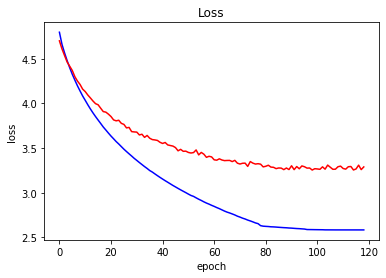

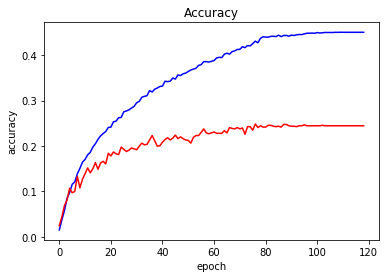

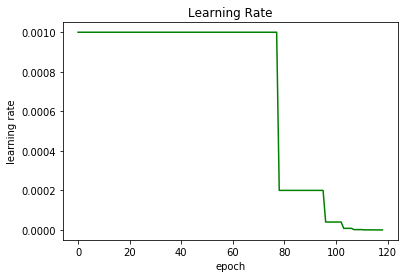

In [14]:
train_loss = history_base.history['loss']
train_acc = history_base.history['accuracy']
val_loss = history_base.history['val_loss']
val_acc = history_base.history['val_accuracy']
learnrate = history_base.history['lr']

plt.plot(train_loss, color='blue')
plt.plot(val_loss, color='red')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(train_acc, color='blue')
plt.plot(val_acc, color='red')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(learnrate, color='green')
plt.title('Learning Rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show()

## Load class details

In [15]:
classes = train_data_gen.class_indices

In [16]:
inverted_classes = dict(map(reversed, classes.items()))

In [17]:
class_list = [i for i in classes.keys()]

## Load test data

In [18]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=TEST_PATH,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode=None)

Found 10357 images belonging to 1 classes.


## Run on test data

In [19]:
test_result = base_model.predict_generator(test_data_gen, verbose=1)

65/65 [==============================] - 43s 657ms/step


## Prepare data for csv

In [20]:
filenames = [i[i.find('/')+1:i.rfind('.')] for i in test_data_gen.filenames]
filenames_arr = np.array(filenames)[np.newaxis].T
test_result_with_label = np.concatenate((filenames_arr, test_result), axis=1)
csv_header = ['id'] + class_list

## Export data to csv

In [21]:
# Be aware that the file with the same name should not exist, or it will be overwrited.
result_dataframe = pd.DataFrame(test_result_with_label, columns=csv_header)
result_dataframe.to_csv('./result_vgg19_2.csv', index=False)